In [23]:
import numpy as np
import math 
import platform
import tempfile
import os
import tempfile
import IPython
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from scipy import signal

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

import mrlab as mr
# necessite scikit-image 
from skimage import io 
from skimage import filters




In [46]:
def viewimage(im, normalize=True,titre='',displayfilename=False):
    imin=im.copy().astype(np.float32)
    if normalize:
        imin-=imin.min()
        if imin.max()>0:
            imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255
        
    
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))
    
def interpolationbilineaire(ima,l,c):

    l,c
    
    l1=l-np.floor(l)
    l2=np.ceil(l)-l
    c1=c-np.floor(c)
    c2=np.ceil(c)-c   


    ll=np.uint32(np.floor(l))
    cc=np.uint32(np.floor(c))

    val=ima[ll,cc]*l2*c2+ima[ll+1,cc]*l1*c2+ima[ll,cc+1]*l2*c1+ima[ll+1,cc+1]*l1*c1

    return val 

def maximaDirectionGradient(gradx,grady):


    nl,nc=gradx.shape
 
    norme=np.sqrt(gradx*gradx+grady*grady)+0.1

    gradx=np.divide(gradx,norme)
    grady=np.divide(grady,norme)
 
    contours=np.zeros((nl,nc),dtype=int);

    for i in range(1,nl-1):
        for j in range(1,nc-1):
            G1=interpolationbilineaire(norme,i+grady[i,j],j+gradx[i,j]); 
            G2=interpolationbilineaire(norme,i-grady[i,j],j-gradx[i,j]); 
            if norme[i,j]>=G1 and norme[i,j]>=G2:
                contours[i,j]=1
            else:
                contours[i,j]=0

    return contours

def sobelGradX(ima):

    nl,nc=ima.shape
    gradx=np.zeros((nl,nc))


#gradx=np.zeros(nl,nc)
    for i in range(1,nl-1):
        for j in range(1,nc-1):
            gradx[i,j]=ima[i-1,j+1]+2*ima[i,j+1]+ima[i+1,j+1]-ima[i-1,j-1]-2*ima[i,j-1]-ima[i+1,j-1];
            
    return gradx

def sobelGradY(ima):

    nl,nc=ima.shape
    grady=np.zeros((nl,nc))


#gradx=np.zeros(nl,nc)
    for i in range(1,nl-1):
        for j in range(1,nc-1):
            grady[i,j]=ima[i+1,j-1]+2*ima[i+1,j]+ima[i+1,j+1]-ima[i-1,j-1]-2*ima[i-1,j]-ima[i-1,j+1];
        
    return grady

def dericheGradX(ima,alpha):

    
    nl,nc=ima.shape
    ae=math.exp(-alpha)
    c=-(1-ae)*(1-ae)/ae

    b1=np.zeros(nc)
    b2=np.zeros(nc)

    gradx=np.zeros((nl,nc))


#gradx=np.zeros(nl,nc)
    for i in range(nl):
        
        l=ima[i,:].copy()
        
        for j in range(2,nc):
            b1[j] = l[j-1]+2*ae*b1[j-1]-ae*ae*b1[j-2]     # LIGNE A MODIFIER
        b1[0]=b1[2]
        b1[1]=b1[2]
        
        for j in range(nc-3,-1,-1):
            b2[j] = l[j+1]+2*ae*b2[j+1]-ae*ae*b2[j+2]      # LIGNE A MODIFIER
        b2[nc-2]=b2[nc-3]
        b2[nc-1]=b2[nc-3]

        gradx[i,:]=c*ae*(b1-b2)
  
    return gradx

def dericheGradY(ima,alpha):

    
    nl,nc=ima.shape
    ae=math.exp(-alpha)
    c=-(1-ae)*(1-ae)/ae

    b1=np.zeros(nl)
    b2=np.zeros(nl)

    grady=np.zeros((nl,nc))

    for i in range(nc):
        
        l=ima[:,i].copy()
        
        for j in range(2,nl):
            b1[j]=l[j-1]+2*ae*b1[j-1]-ae*ae*b1[j-2]   # LIGNE A MODIFIER
        b1[0]=b1[2]
        b1[1]=b1[2]      
        
        for j in range(nl-3,-1,-1):
            b2[j]=l[j+1]+2*ae*b2[j+1]-ae*ae*b2[j+2]    # LIGNE A MODIFIER
        b2[nl-1]=b2[nl-3]
        b2[nl-2]=b2[nl-3]
        
        grady[:,i]=c*ae*(b1-b2)
        
    
    return grady

def dericheSmoothX(ima,alpha):

    
    nl,nc=ima.shape
    ae=math.exp(-alpha)
    c=(1-ae)*(1-ae)/(1+2*alpha*ae-ae*ae)


    b1=np.zeros(nc)
    b2=np.zeros(nc)

    smoothx=np.zeros((nl,nc))


#gradx=np.zeros(nl,nc)
    for i in range(nl):
        l=ima[i,:].copy()
        for j in range(2,nc):
            b1[j]=c*(l[j]+ae*(alpha-1)*l[j-1])+2*ae*b1[j-1]-ae*ae*b1[j-2]
        b1[0]=b1[2]
        b1[1]=b1[2]
        for j in range(nc-3,-1,-1):
            b2[j]=c*(ae*(alpha+1)*l[j+1]-ae*ae*l[j+2])+2*ae*b2[j+1]-ae*ae*b2[j+2]
        b2[nc-1]=b2[nc-3]
        b2[nc-2]=b2[nc-3]
        smoothx[i,:]=b1+b2
        
    
    return smoothx

def dericheSmoothY(ima,alpha):

    
    nl,nc=ima.shape
    ae=math.exp(-alpha)
    c=(1-ae)*(1-ae)/(1+2*alpha*ae-ae*ae)

    b1=np.zeros(nl)
    b2=np.zeros(nl)

    smoothy=np.zeros((nl,nc))

    for i in range(nc):
        l=ima[:,i].copy()
        for j in range(2,nl):
            b1[j]=c*(l[j]+ae*(alpha-1)*l[j-1])+2*ae*b1[j-1]-ae*ae*b1[j-2]
        b1[0]=b1[2]
        b1[1]=b1[2]      
        for j in range(nl-3,-1,-1):
            b2[j]=c*(ae*(alpha+1)*l[j+1]-ae*ae*l[j+2])+2*ae*b2[j+1]-ae*ae*b2[j+2]
        b2[nl-1]=b2[nl-3]
        b2[nl-2]=b2[nl-3]
        
        smoothy[:,i]=b1+b2
        
    
    return smoothy

def median_filter(im,typ=1,r=1,xy=None):
    """ renvoie le median de l'image im.
    si typ==1 (defaut) le median est calcule sur un carre de cote 2r+1
    si typ==2 : disque de rayon r
    si typ==3 alors xy est un couple de liste de x et liste de y
         ([-1,0,1] , [0,0,0]) donne un median sur un segment horizontql de taille trois. 
         """
    lx=[]
    ly=[]
    (ty,tx)=im.shape
    if typ==1: #carre
        
        for k in range(-r,r+1):
            for l in range(-r,r+1):
                lx.append(k)
                ly.append(l)
        
    elif typ==2:
        for k in range(-r,r+1):
            for l in range(-r,r+1):
                if k**2+l**2<=r**2:
                    lx.append(k)
                    ly.append(l)
    else: #freeshape
        lx,ly=xy
    
    debx=-min(lx) #min is supposed negatif
    deby=-min(ly)
    finx=tx-max(lx) #max is supposed positif
    finy=ty-max(ly)
    ttx=finx-debx
    tty=finy-deby
    tab=np.zeros((len(lx),ttx*tty))
    #print (lx,ly)
    #print(ttx,tty)
    #print(im[deby+ly[k]:tty+ly[k]+deby,debx+lx[k]:debx+ttx+lx[k]].reshape(-1).shape)
    for k in range(len(lx)):
        tab[k,:]=im[deby+ly[k]:deby+tty+ly[k],debx+lx[k]:debx+ttx+lx[k]].reshape(-1)
    out=im.copy()
    out[deby:finy,debx:finx]=np.median(tab,axis=0).reshape((tty,ttx))
    return out

1.2 Maximum du gradient filtré dans la direction du gradient

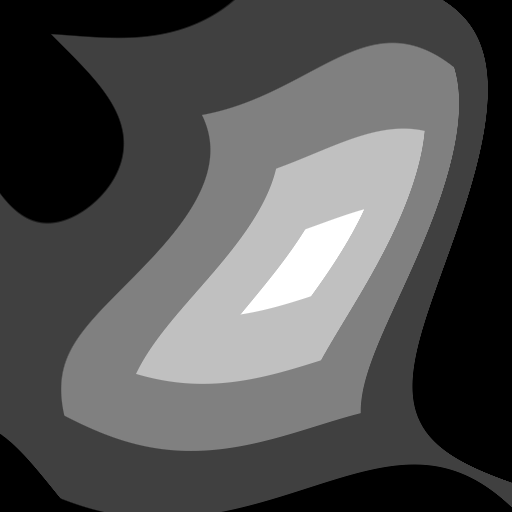

In [25]:
im=io.imread('pyramide.tif')
viewimage(im)

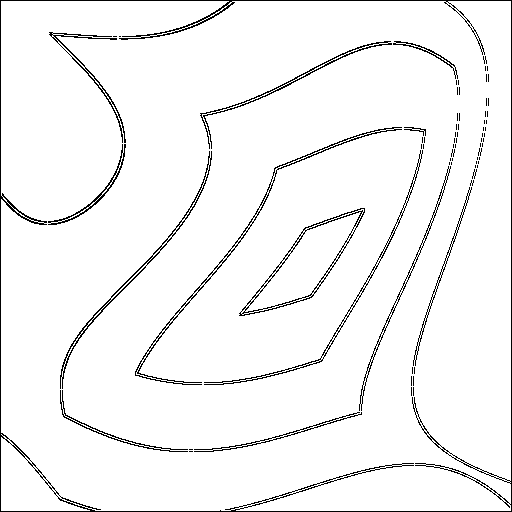

In [26]:
gradx,grady=sobelGradX(im),sobelGradY(im)
viewimage(maximaDirectionGradient(gradx,grady))

<Figure size 640x480 with 0 Axes>

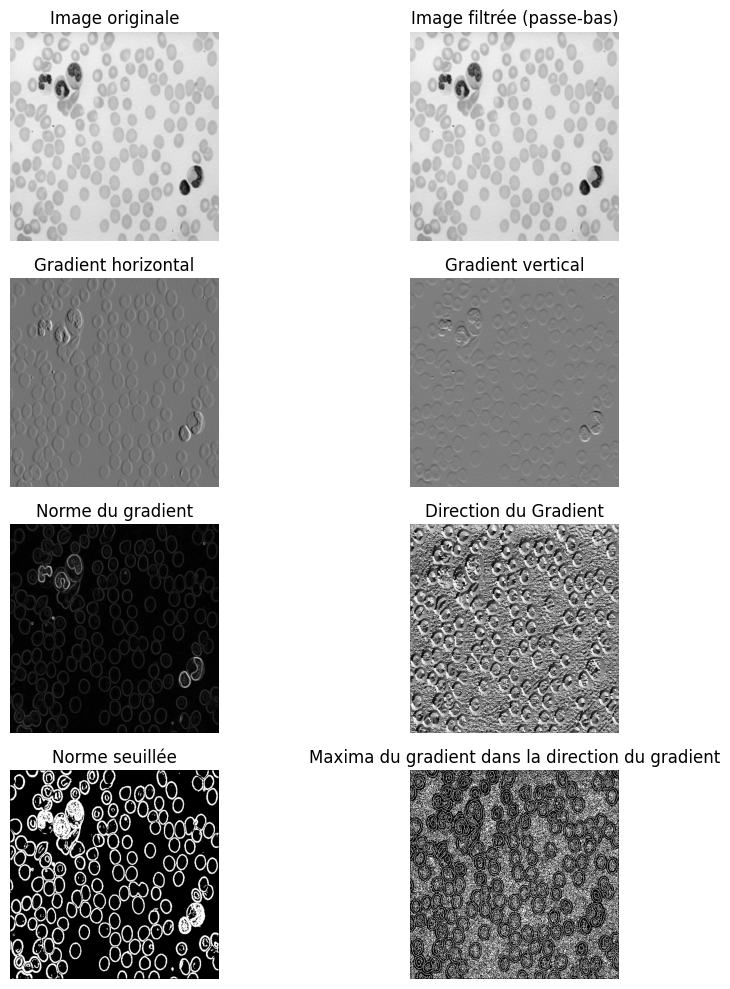

In [27]:
ima=io.imread('cell.tif')
sigma=0
seuilnorme=0.1


gfima=filters.gaussian(ima,sigma)

plt.figure('Image originale')
fig, axs = plt.subplots(4,2,figsize=(10, 10))
axs[0,0].imshow(ima, cmap='gray')
axs[0,0].set_title('Image originale')
axs[0,1].imshow(gfima, cmap='gray')
axs[0,1].set_title('Image filtrée (passe-bas)')

gradx=mr.sobelGradX(gfima)
grady=mr.sobelGradY(gfima)  

axs[1,0].imshow(gradx, cmap='gray')
axs[1,0].set_title('Gradient horizontal')

axs[1,1].imshow(grady, cmap='gray')
axs[1,1].set_title('Gradient vertical')

norme=np.sqrt(gradx*gradx+grady*grady)
axs[2,0].imshow(norme, cmap='gray')
axs[2,0].set_title('Norme du gradient')

direction=np.arctan2(grady,gradx)
axs[2,1].imshow(direction, cmap='gray')
axs[2,1].set_title('Direction du Gradient')

contoursnorme =(norme>seuilnorme) 
axs[3,0].imshow(255*contoursnorme, cmap='gray')
axs[3,0].set_title('Norme seuillée')

contours=np.uint8(mr.maximaDirectionGradient(gradx,grady))
axs[3,1].imshow(255*contours, cmap='gray')
axs[3,1].set_title('Maxima du gradient dans la direction du gradient')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()


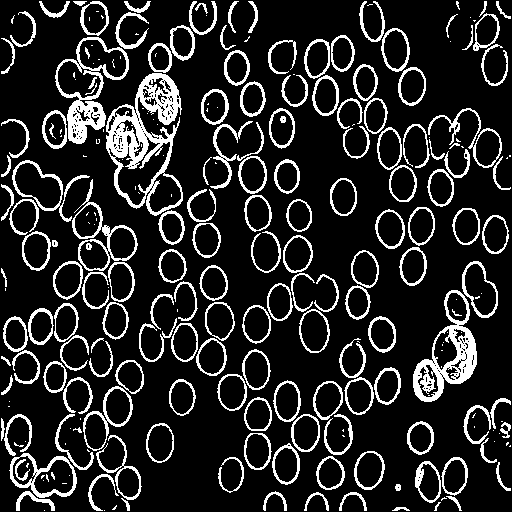

In [38]:
seuilnorme=0.15
contoursnorme =(norme>seuilnorme) 
viewimage(255*contoursnorme)

1.3 Filtre récursif de Deriche

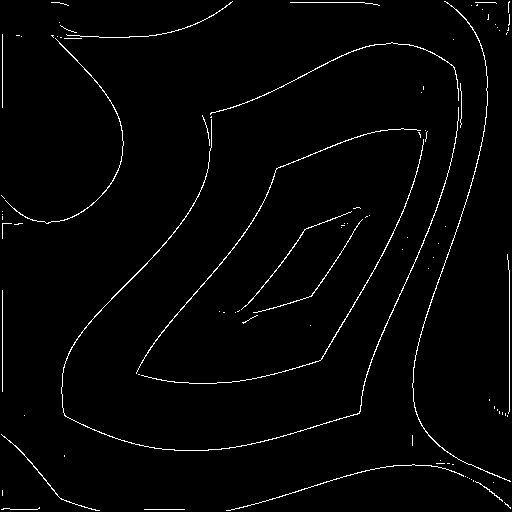

In [42]:
im=io.imread('pyramide.tif')
#fig, axs = plt.subplots(1,2,figsize=(10, 10))

alpha=0.1

gradx,grady=dericheGradX(im,alpha),dericheGradY(im,alpha)
#axs[0].imshow(maximaDirectionGradient(gradx,grady), cmap='gray')
viewimage(maximaDirectionGradient(gradx,grady))
#gradx,grady=dericheSmoothX(im,alpha),dericheSmoothY(im,alpha)
#axs[1].imshow(maximaDirectionGradient(gradx,grady), cmap='gray')



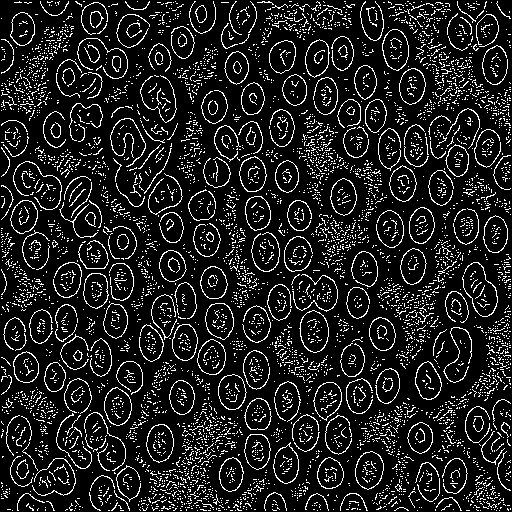

In [72]:
im=io.imread('cell.tif')

alpha = 0.5

gradx,grady=dericheGradX(im,alpha),dericheGradY(im,alpha)
viewimage(maximaDirectionGradient(gradx,grady))


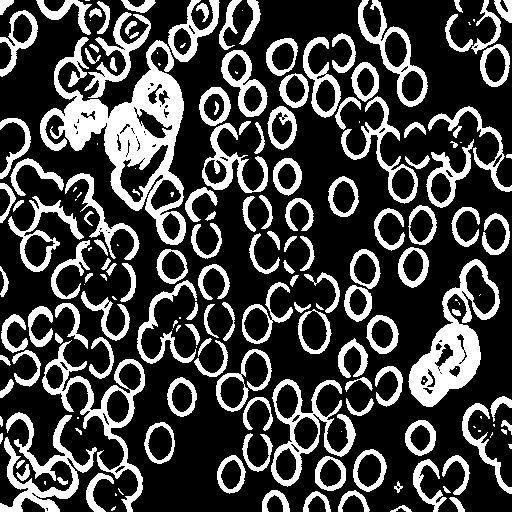

In [80]:
norme=np.sqrt(gradx*gradx+grady*grady)
seuilnorme=15
contoursnorme =(norme>seuilnorme) 
viewimage(255*contoursnorme)

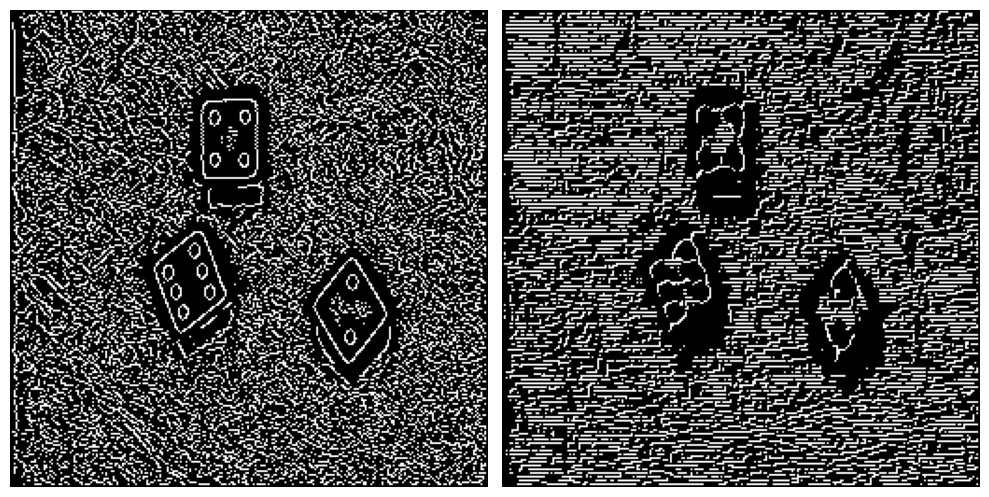

In [10]:
im=io.imread('dice1.tif')
fig, axs = plt.subplots(1,2,figsize=(10, 10))

alpha=1

gradx,grady=dericheGradX(im,alpha),dericheGradY(im,alpha)
axs[0].imshow(maximaDirectionGradient(gradx,grady), cmap='gray')

gradx,grady=dericheSmoothX(im,alpha),dericheSmoothY(im,alpha)
axs[1].imshow(maximaDirectionGradient(gradx,grady), cmap='gray')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()

1.4 Passage par zéro du laplacien

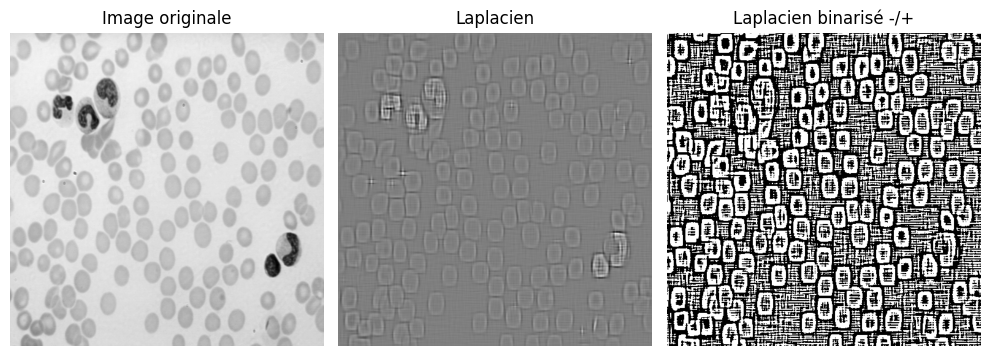

In [11]:
ima=io.imread('cell.tif')
alpha=0.5

gradx=mr.dericheGradX(mr.dericheSmoothY(ima,alpha),alpha)
grady=mr.dericheGradY(mr.dericheSmoothX(ima,alpha),alpha)  

gradx2=mr.dericheGradX(mr.dericheSmoothY(gradx,alpha),alpha)
grady2=mr.dericheGradY(mr.dericheSmoothX(grady,alpha),alpha)  

fig, axs = plt.subplots(1,3,figsize=(10, 10))

axs[0].imshow(ima, cmap='gray')
axs[0].set_title('Image originale')
lpima=gradx2+grady2
axs[1].imshow(lpima, cmap='gray')
axs[1].set_title('Laplacien')
posneg=(lpima>=0)
axs[2].imshow(255*posneg, cmap='gray')
axs[2].set_title('Laplacien binarisé -/+')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()

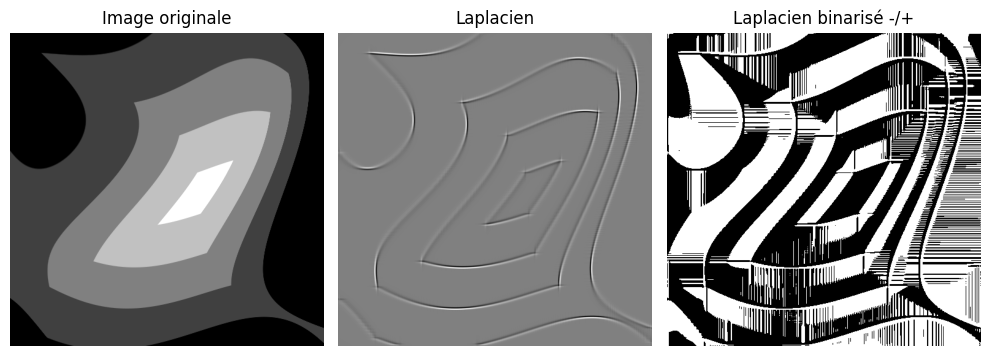

In [12]:
ima=io.imread('pyramide.tif')
alpha=0.5

gradx=mr.dericheGradX(mr.dericheSmoothY(ima,alpha),alpha)
grady=mr.dericheGradY(mr.dericheSmoothX(ima,alpha),alpha)  

gradx2=mr.dericheGradX(mr.dericheSmoothY(gradx,alpha),alpha)
grady2=mr.dericheGradY(mr.dericheSmoothX(grady,alpha),alpha)  

fig, axs = plt.subplots(1,3,figsize=(10, 10))

axs[0].imshow(ima, cmap='gray')
axs[0].set_title('Image originale')
lpima=gradx2+grady2
axs[1].imshow(lpima, cmap='gray')
axs[1].set_title('Laplacien')
posneg=(lpima>=0)
axs[2].imshow(255*posneg, cmap='gray')
axs[2].set_title('Laplacien binarisé -/+')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()

1.5 Changer d'image : Pyra-gauss

C:\Users\m\AppData\Local\Temp\ipykernel_35312\2538487634.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


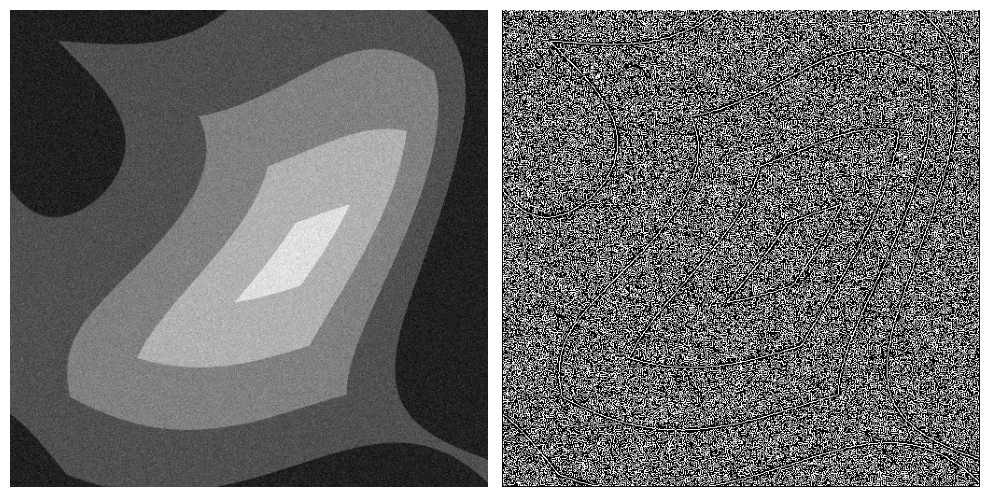

In [13]:
im=io.imread('pyra-gauss.tif')
fig, axs = plt.subplots(1,2,figsize=(10, 10))

gradx,grady=dericheGradX(im,3),dericheGradY(im,3)
axs[0].imshow(maximaDirectionGradient(gradx,grady), cmap='gray')

gradx,grady=dericheSmoothX(im,3),dericheSmoothY(im,3)
axs[1].imshow(maximaDirectionGradient(gradx,grady), cmap='gray')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
axs[0].imshow(im, cmap='gray')

gradx,grady=sobelGradX(im),sobelGradY(im)
axs[1].imshow(maximaDirectionGradient(gradx,grady), cmap='gray')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()

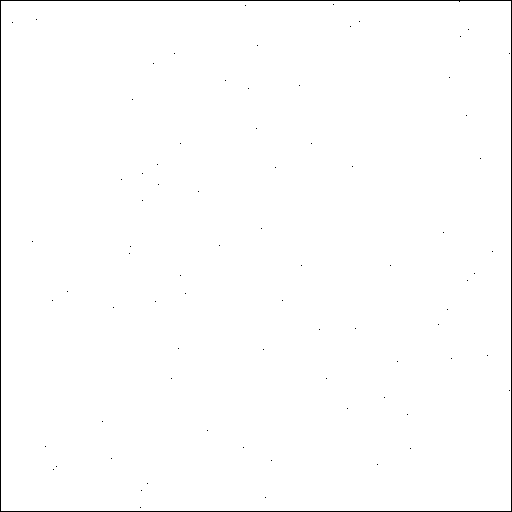

In [14]:
seuilnorme=0.5
gradx,grady=sobelGradX(im),sobelGradY(im)
norme=np.sqrt(gradx*gradx+grady*grady)
contoursnorme =(norme>seuilnorme) 
viewimage(255*contoursnorme)


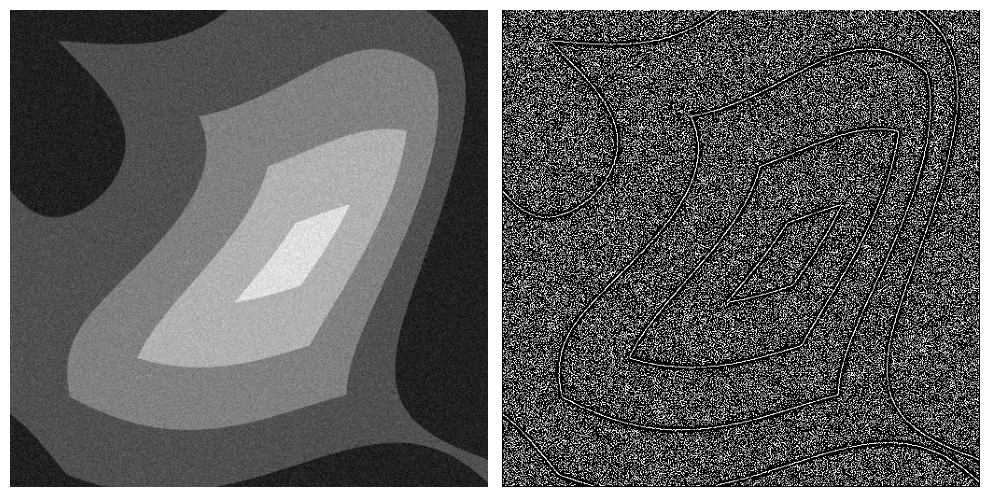

In [15]:
im=io.imread('pyra-gauss.tif')
fig, axs = plt.subplots(1,2,figsize=(10, 10))


axs[0].imshow(im, cmap='gray')

gradx,grady=dericheGradX(im,1),dericheGradY(im,1)
axs[1].imshow(maximaDirectionGradient(gradx,grady), cmap='gray')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()

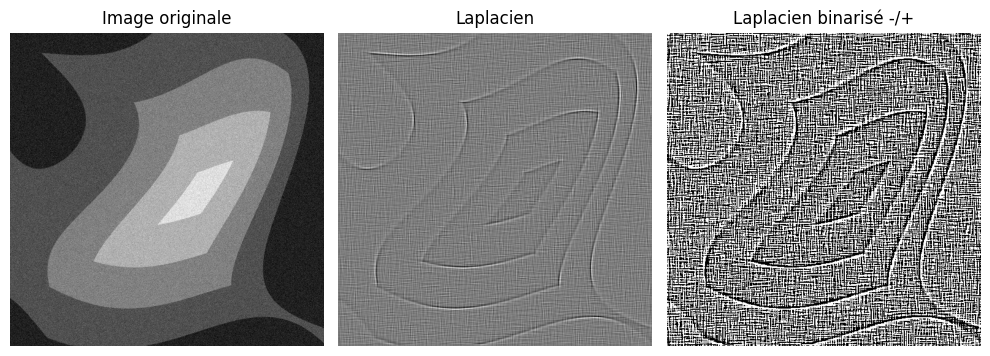

In [16]:
ima=io.imread('pyra-gauss.tif')
alpha=0.5

gradx=mr.dericheGradX(mr.dericheSmoothY(ima,alpha),alpha)
grady=mr.dericheGradY(mr.dericheSmoothX(ima,alpha),alpha)  

gradx2=mr.dericheGradX(mr.dericheSmoothY(gradx,alpha),alpha)
grady2=mr.dericheGradY(mr.dericheSmoothX(grady,alpha),alpha)  

fig, axs = plt.subplots(1,3,figsize=(10, 10))

axs[0].imshow(ima, cmap='gray')
axs[0].set_title('Image originale')
lpima=gradx2+grady2
axs[1].imshow(lpima, cmap='gray')
axs[1].set_title('Laplacien')
posneg=(lpima>=0)
axs[2].imshow(255*posneg, cmap='gray')
axs[2].set_title('Laplacien binarisé -/+')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()

2 Seuillage avec hystérésis

3 Segmentation par classification : K-moyennes

Fitting model on a small sub-sample of the data


C:\Users\m\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\m\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\m\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


done in 1.105s.
Predicting color indices on the full image (k-means)
done in 0.000s.


C:\Users\m\AppData\Local\Temp\ipykernel_35312\905705161.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  image[i][j] = codebook[labels[label_idx]]


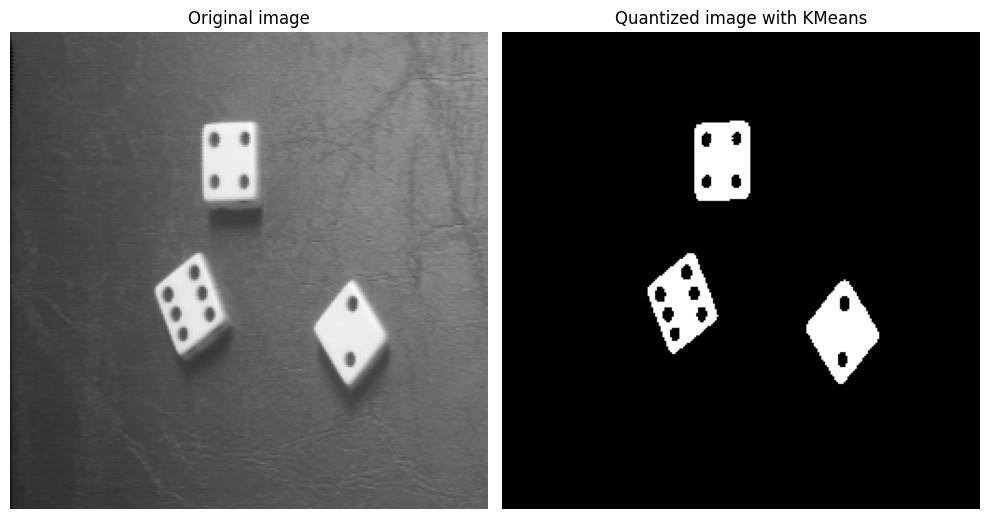

In [17]:
n_class = 2

ima=io.imread('dice1.tif')
ima = np.array(ima, dtype=np.float64) / 255

w, h = original_shape = tuple(ima.shape)
d = 1
image_array = np.reshape(ima, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_class, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    image = np.zeros((w, h))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image


fig, axs = plt.subplots(1,2,figsize=(10, 10))
axs[0].imshow(ima,cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(recreate_image(kmeans.cluster_centers_, labels, w, h),cmap='gray')
axs[1].set_title('Quantized image with KMeans')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()

Fitting model on a small sub-sample of the data
done in 0.197s.
Predicting color indices on the full image (k-means)


C:\Users\m\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


done in 0.022s.


C:\Users\m\AppData\Local\Temp\ipykernel_35312\3241309667.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  image[i][j] = codebook[labels[label_idx]]


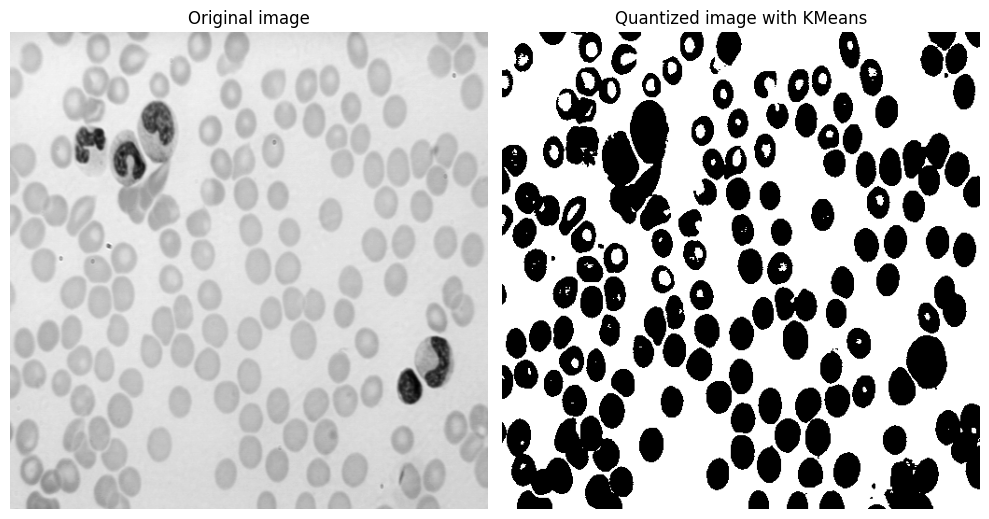

In [18]:
n_class = 2

ima=io.imread('cell.tif')
ima = np.array(ima, dtype=np.float64) / 255

w, h = original_shape = tuple(ima.shape)
d = 1
image_array = np.reshape(ima, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_class, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    image = np.zeros((w, h))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image


fig, axs = plt.subplots(1,2,figsize=(10, 10))
axs[0].imshow(ima,cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(recreate_image(kmeans.cluster_centers_, labels, w, h),cmap='gray')
axs[1].set_title('Quantized image with KMeans')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()

Fitting model on a small sub-sample of the data


C:\Users\m\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


done in 0.225s.
Predicting color indices on the full image (k-means)
done in 0.009s.


C:\Users\m\AppData\Local\Temp\ipykernel_35312\4289878928.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  image[i][j] = codebook[labels[label_idx]]


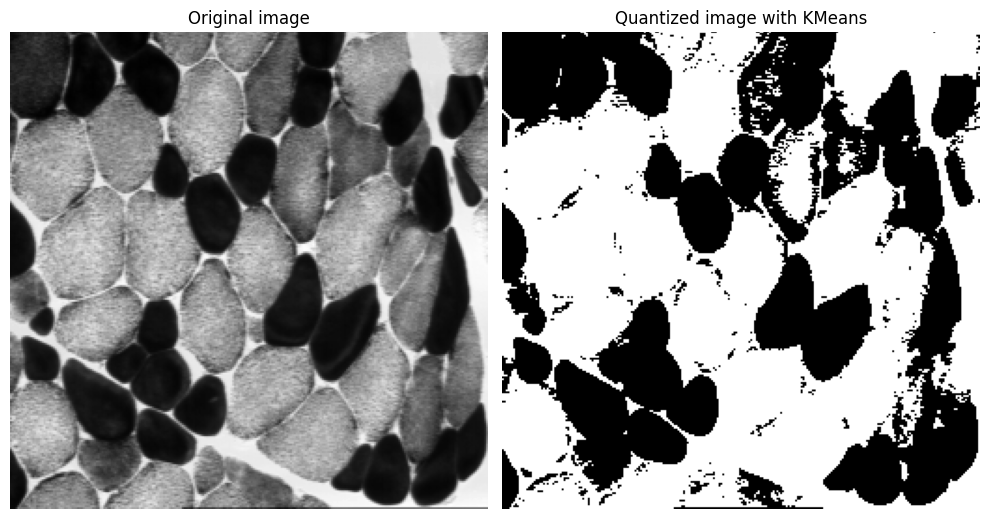

In [19]:
n_class = 2

ima=io.imread('muscle.tif')
ima = np.array(ima, dtype=np.float64) / 255

w, h = original_shape = tuple(ima.shape)
d = 1
image_array = np.reshape(ima, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_class, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    image = np.zeros((w, h))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image


fig, axs = plt.subplots(1,2,figsize=(10, 10))
axs[0].imshow(ima,cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(recreate_image(kmeans.cluster_centers_, labels, w, h),cmap='gray')
axs[1].set_title('Quantized image with KMeans')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()

Fitting model on a small sub-sample of the data
done in 0.142s.
Predicting color indices on the full image (k-means)
done in 0.028s.


C:\Users\m\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\m\AppData\Local\Temp\ipykernel_35312\3682792445.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  image[i][j] = codebook[labels[label_idx]]


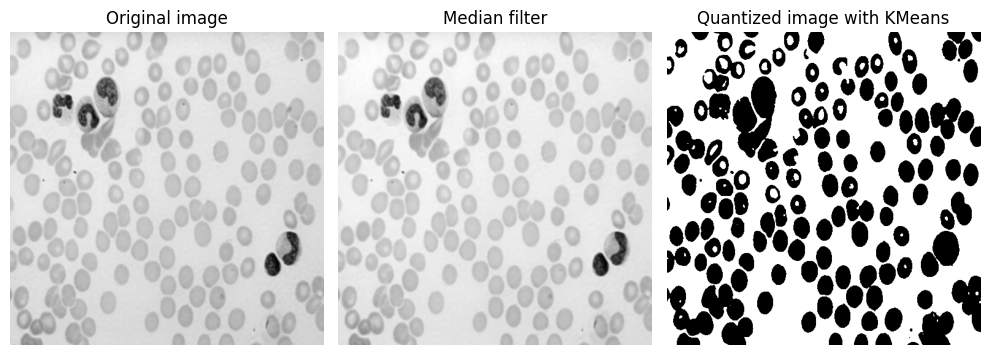

In [20]:
#filtrage avant ségmentation

n_class = 2

im=io.imread('cell.tif')
ima=median_filter(im)
ima = np.array(ima, dtype=np.float64) / 255

w, h = original_shape = tuple(ima.shape)
d = 1
image_array = np.reshape(ima, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_class, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    image = np.zeros((w, h))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image


fig, axs = plt.subplots(1,3,figsize=(10, 10))
axs[0].imshow(im,cmap='gray')
axs[0].set_title('Original image')

axs[1].imshow(ima,cmap='gray')
axs[1].set_title('Median filter')

axs[2].imshow(recreate_image(kmeans.cluster_centers_, labels, w, h),cmap='gray')
axs[2].set_title('Quantized image with KMeans')

for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()

Fitting model on a small sub-sample of the data


C:\Users\m\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


done in 0.234s.
Predicting color indices on the full image (k-means)
done in 0.024s.


Text(0.5, 1.0, 'Quantized image with K-Means: 5 colours')

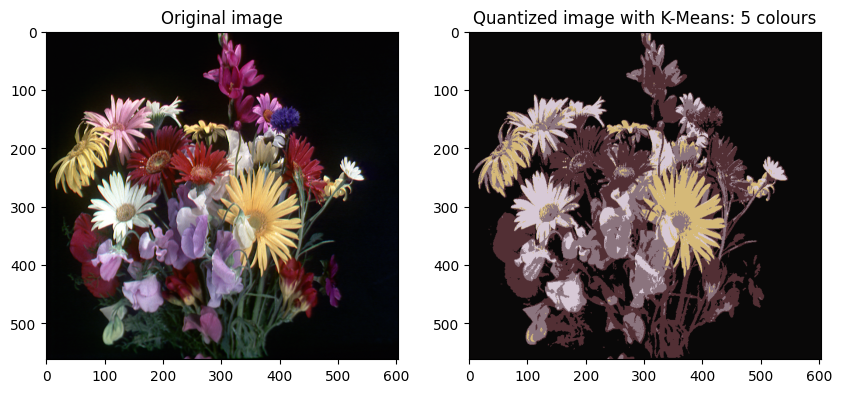

In [21]:
n_colors = 5

ima = io.imread("fleur.tif")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
ima = np.array(ima, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(ima.shape)
assert d == 3
image_array = np.reshape(ima, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

fig, axs = plt.subplots(1,2,figsize=(10, 10))
axs[0].imshow(ima,cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(recreate_image(kmeans.cluster_centers_, labels, w, h),cmap='gray')
axs[1].set_title('Quantized image with K-Means: %i colours' %n_colors)